# Imports

In [1]:
#pip install pandas scipy matplotlib numpy scikit-learn tqdm torch tensorflow joblib keras seaborn google-colab

In [2]:
####imports
import pandas as pd
from scipy import stats
import io
import matplotlib.ticker as ticker
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
import math
from tqdm import tqdm
from datetime import datetime
import os
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import keras
import seaborn as sns
import torch
from google.colab import files

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [3]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['synthetic_data.csv']))

Saving synthetic_data.csv to synthetic_data.csv


In [4]:
#Exclusion Criteria

#Remove Patients who enter after 75
df = df[df['age_enter']<75.0]

#Remove Patient with less than 6 months of availible data
available_data= df['age_end'] - df['age_enter']
df = df[available_data > 0.5]

In [5]:
df

,nam,sex,severeCHD,age_enter,age_end,age_death,death,syndrome,age_HFH1,age_HFH2,...,age_AKD282,age_AKD283,age_AKD284,age_AKD285,age_AKD286,age_AKD287,age_AKD288,age_AKD289,age_COPD,age_OSA
0,0,F,0,0.000000,14.363439,NaN,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M,0,0.000000,0.612376,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162879
2,2,F,0,0.000000,3.868795,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M,1,0.000000,6.076010,NaN,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M,0,19.950719,50.513489,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,F,1,0.000000,3.126937,NaN,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49996,49996,M,1,0.000000,17.902694,NaN,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49997,49997,F,0,0.000000,18.659187,NaN,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49998,49998,F,1,0.000000,20.913620,NaN,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#To run the code faster
sample = df.head(2000)

# Preprocessing

In [7]:
############# DEFINE THE GROUPS OF VARIABLES ###############

#Time varying
hf_cols = [f'age_HFH{i}' for i in range(1, 37)]
mi_cols = [f'age_MI{i}' for i in range(1, 19)]
stroke_cols = [f'age_Stroke{i}' for i in range(1, 33)]
ie_cols = [f'age_IE{i}' for i in range(1, 31)]
arr_cols = [f'age_ARR{i}' for i in range(1, 274)]
varr_cols =[f'age_VARR{i}' for i in range(1, 101)]
congsx_cols =[f'age_CONGSX{i}' for i in range(1, 8)]
arrsx_cols =[f'age_ARRSX{i}' for i in range(1, 4)]
pcl_cols =[f'age_PCI{i}' for i in range(1, 45)]
sepsis_cols =[f'age_Sepsis{i}' for i in range(1, 17)]
akd_cols =[f'age_AKD{i}' for i in range(1, 290)]


#Initial Condition
birth_cols = ['sex', 'syndrome']

#Diagnoses
diagnoses_cols = [
    'CAD',
    'HPT',
    'PH',
    'DIAB',
    'CKD',
    'CLD',
    'COPD',
    'OSA'
]
diagnoses_time_col = list(map(lambda st: f'age_{st}', diagnoses_cols))


In [8]:
############ PREPROCESS THE DATA INTO EVENT BASED SEQUENCE ################

def preprocess(df):

  #df.drop(columns=ignored_cols, inplace=True)

  """ hf """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  hf = df[['nam'] + hf_cols].copy()
  #remove duplicates
  hf = hf.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  hf_record = hf.melt(id_vars=['nam'])
  #remove NaN
  hf_record = hf_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  hf_record = hf_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  hf_record.value = hf_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """  mi """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  mi = df[['nam'] + mi_cols].copy()
  #remove duplicates
  mi = mi.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  mi_record = mi.melt(id_vars=['nam'])
  #remove NaN
  mi_record = mi_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  mi_record = mi_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  mi_record.value = mi_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """ stroke """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  stroke = df[['nam'] + stroke_cols].copy()
  #remove duplicates
  stroke = stroke.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  stroke_record = stroke.melt(id_vars=['nam'])
  #remove NaN
  stroke_record = stroke_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  stroke_record = stroke_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  stroke_record.value = stroke_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """ ie """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  ie = df[['nam'] + ie_cols].copy()
  #remove duplicates
  ie = ie.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  ie_record = ie.melt(id_vars=['nam'])
  #remove NaN
  ie_record = ie_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  ie_record = ie_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  ie_record.value = ie_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """arr """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  arr= df[['nam'] + arr_cols].copy()
  #remove duplicates
  arr = arr.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  arr_record = arr.melt(id_vars=['nam'])
  #remove NaN
  arr_record = arr_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  arr_record = arr_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  arr_record.value = arr_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """varr """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  varr= df[['nam'] + varr_cols].copy()
  #remove duplicates
  varr = varr.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  varr_record = varr.melt(id_vars=['nam'])
  #remove NaN
  varr_record = varr_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  varr_record = varr_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  varr_record.value = varr_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """congsx """
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  congsx= df[['nam'] + congsx_cols].copy()
  #remove duplicates
  congsx = congsx.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  congsx_record = congsx.melt(id_vars=['nam'])
  #remove NaN
  congsx_record = congsx_record.dropna().sort_values('nam')
  #reset_index and drop variable(age_allSX)
  congsx_record = congsx_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  congsx_record.value = congsx_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """arrsx"""
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  arrsx= df[['nam'] + arrsx_cols].copy()
  #remove duplicates
  arrsx = arrsx.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  arrsx_record = arrsx.melt(id_vars=['nam'])
  #remove NaN
  arrsx_record = arrsx_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  arrsx_record = arrsx_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  arrsx_record.value = arrsx_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """pcl"""
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  pcl= df[['nam'] + pcl_cols].copy()
  #remove duplicates
  pcl = pcl.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  pcl_record = pcl.melt(id_vars=['nam'])
  #remove NaN
  pcl_record = pcl_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  pcl_record = pcl_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  pcl_record.value = pcl_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """sepsis"""
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  sepsis= df[['nam'] + sepsis_cols].copy()
  #remove duplicates
  sepsis = sepsis.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  sepsis_record = sepsis.melt(id_vars=['nam'])
  #remove NaN
  sepsis_record = sepsis_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  sepsis_record = sepsis_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  sepsis_record.value = sepsis_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """akd"""
  #create surgery record for each patient -> output is a record with two columns(nam and age of surgery)
  #row name and all surgeries
  akd= df[['nam'] + akd_cols].copy()
  #remove duplicates
  akd = akd.drop_duplicates()
  #transform into nam+variable+value basically verticalize
  akd_record = akd.melt(id_vars=['nam'])
  #remove NaN
  akd_record = akd_record.dropna().sort_values('nam')
  #reset_index and drop variable( age_allSX)
  akd_record = akd_record.reset_index(drop=True).drop(columns=['variable'])
  # Discretize the age to be in a 6-month bucket ->>> round the value
  akd_record.value = akd_record.value.apply(lambda age: round(age * 2) / 2)
  # result is a 2 column df with nam and value showing all surgeries ages based on nam

  """ Diagnoses """
  #row will all nam + diagnosis (8 columns)
  diagnoses = df[['nam'] + diagnoses_time_col].drop_duplicates()
  #transform vertically to 3 columns (nam+vairable(8)+value(age))
  diagnoses_record = diagnoses.melt(id_vars=['nam']).sort_values(['nam', 'variable'])
  #change NaN to inf and reset index
  diagnoses_record = diagnoses_record.reset_index(drop=True).fillna(np.inf)
  #set nam as index
  diagnoses_record = diagnoses_record.set_index('nam')
  # result is a 3 column df with nam(index), variable (8 per person), value(age)
  # ['CAD','ARR','VARR','PH','DIAB','Stroke','CLD','CKD']

  """ birth record """
  # 3 column -> nam + (sexe,lesion)
  birth_record = df[['nam'] + birth_cols].drop_duplicates()
  #sort by nam
  birth_record = birth_record.reset_index(drop=True).sort_values(['nam'])
  # change sexe(M or F)-> sex_F and sex_M binary variables and Genetic Syndrome
  birth_record = pd.get_dummies(birth_record)
  #let nam be the index
  birth_record = birth_record.set_index('nam')
  # result is a 7 columns df with nam(index), 6 variable (2 sexe + 1 syndrome)
  # ['M','F', 'syndrome']

  """ HF record """
  # 4 columns -> [nam,	HF,	ageT0,	age_end]
  age_record = df[['nam', 'age_enter', 'age_end']].copy()
  # Set index to be nam
  age_record = age_record.set_index('nam')
  # Round HF age to nearest 6-month interval (0.5 year), and round up the end age
  age_record.age_enter = np.round(age_record.age_enter * 2.) / 2.
  age_record.age_end = np.ceil(age_record.age_end * 2.) / 2.
  #extract just unique ids
  all_patient_ids = age_record.index.unique()
  remaining_patient_ids = []
  cms = []
  hf_labels = []
  cm_labels = []

  for patient_id in tqdm(all_patient_ids):
      #one row based all based on the same patient_id
      patient_birth_rec = birth_record.loc[patient_id]
      patient_diag_rec = diagnoses_record.loc[patient_id]
      patient_age_rec = age_record.loc[patient_id]
      #age
      age_start = 0
      #age_start = patient_age_rec.age_enter.min()
      age_end = patient_age_rec.age_end.max()



      # pass through the function below
      patient_cms, patient_hf_labels = compute_patient_cms_labels(
          patient_id,
          patient_age_rec,
          patient_diag_rec,
          patient_birth_rec,
          #surgery_record,
          hf_record,
          mi_record,
          stroke_record,
          ie_record,
          arr_record,
          varr_record,
          congsx_record,
          arrsx_record,
          pcl_record,
          sepsis_record,
          akd_record,
          age_start,
          age_end
      )

      cms.append(patient_cms)
      hf_labels.append(patient_hf_labels)
      #cm_labels.append(patient_cm_labels)
      remaining_patient_ids.append(patient_id)

  """ MERGE """
  return remaining_patient_ids, cms, hf_labels

In [9]:
######### HELPER FUNCTION TO TRANFORM SEQUENCE INTO 6-MONTH INTERVALS #########
def compute_patient_cms_labels(patient_id,patient_age_rec,patient_diag_rec,patient_birth_rec,hf_record,mi_record,stroke_record,ie_record,arr_record,varr_record,congsx_record,arrsx_record,pcl_record,sepsis_record,akd_record,age_start,age_end):
    patient_cms = []
    patient_hf_labels = []

    age_start = max(0, age_start)

    for age in np.arange(age_start, age_end+1, 0.5):
        # Compute the birth records and permanent CMs
        single_birth_cm = patient_birth_rec.values
        single_diag_cm = np.array(patient_diag_rec.value < age, dtype=int)

        # Compute temporal CMs and surgery
        #single_surg_label = np.any((surgery_record.nam == patient_id) & (surgery_record.value == age)).astype(int)
        hf_current = np.any((hf_record.nam == patient_id) & (hf_record.value == age)).astype(int)
        hf_next = np.any((hf_record.nam == patient_id) & (hf_record.value == age+0.5)).astype(int)
        #print(mi_record.nam)
        mi_record1 = np.any((mi_record.nam == patient_id) & (mi_record.value == age)).astype(int)
        stroke_record1 = np.any((stroke_record.nam == patient_id) & (stroke_record.value == age)).astype(int)
        ie_record1 = np.any((ie_record.nam == patient_id) & (ie_record.value == age)).astype(int)
        arr_record1 = np.any((arr_record.nam == patient_id) & (arr_record.value == age)).astype(int)
        varr_record1 = np.any((varr_record.nam == patient_id) & (varr_record.value == age)).astype(int)
        arrsx_record1 = np.any((arrsx_record.nam == patient_id) & (arrsx_record.value == age)).astype(int)
        congsx_record1 = np.any((congsx_record.nam == patient_id) & (congsx_record.value == age)).astype(int)
        pcl_record1 = np.any((pcl_record.nam == patient_id) & (pcl_record.value == age)).astype(int)
        sepsis_record1 = np.any((sepsis_record.nam == patient_id) & (sepsis_record.value == age)).astype(int)
        akd_record1 = np.any((akd_record.nam == patient_id) & (akd_record.value == age)).astype(int)



        # Compute next temporal CMs
        #single_temp_cm = np.array(patient_temp_rec.value == age + 0.5, dtype=int)

        # Concatenate the CMs
        single_cms = np.concatenate([
            single_birth_cm, single_diag_cm,
            np.array([mi_record1,stroke_record1,ie_record1,arr_record1,varr_record1, congsx_record1,arrsx_record1,pcl_record1,sepsis_record1,akd_record1, hf_current, age])
        ])
        patient_cms.append(single_cms)
        patient_hf_labels.append(hf_next)
        #patient_cm_labels.append(single_temp_cm)

    patient_cms = np.stack(patient_cms)
    #patient_cm_labels = np.stack(patient_cm_labels)
    patient_hf_labels = np.array(patient_hf_labels)

    return patient_cms, patient_hf_labels

In [10]:
######## APPLY PREPROCESSING #########

# For each patient we turn event based data into sequencial data (cms = input, hf_labels = output)
#ids,cms,hf_labels = preprocess(df)

df_train, df_test = train_test_split(sample, test_size=0.2)

train_ids,train_cms,train_hf_labels = preprocess(df_train)
test_ids,test_cms,test_hf_labels = preprocess(df_test)

#ids,cms,hf_labels = preprocess(sample)

100%|██████████| 400/400 [02:29<00:00,  2.67it/s]


In [11]:
####### TRAIN AND TEST SPLIT
def remove_first_row(patients):
    for i in range(len(patients)):
        patients[i] = np.delete(patients[i], 0, axis=0)
    return patients

def cut_rows(patient_data):
    """
    Cuts the last n-150 rows from each patient's data.

    Args:
    - patient_data: a list of 2D numpy arrays, where each array represents the data for a single patient and has shape (n, 23).

    Returns:
    - A list of 2D numpy arrays, where each array represents the data for a single patient and has shape (150, 23).
    """
    new_patient_data = []
    for patient in patient_data:
        n = patient.shape[0]
        if n > 150:
            new_patient_data.append(patient[0:150,:])
        else:
            new_patient_data.append(patient)
    return new_patient_data


train_input = cut_rows(train_cms)
test_input = cut_rows(test_cms)

train_next = cut_rows(remove_first_row(train_cms))
test_next = cut_rows(remove_first_row(test_cms))

train_hf = [arr[:, -2] for arr in train_next]
test_hf = [arr[:, -2] for arr in test_next]

In [12]:
#### POST PADDING TO MAKE SURE THAT ALL SEQUENCES ARE THE SAME LENGTH #######
def pad(train_cms, train_labels, test_cms, test_labels):
    X_train = pad_sequences(train_cms, value=-1, padding='post', dtype='float32')
    y_train = pad_sequences(train_labels,maxlen=X_train.shape[1])

    X_test = pad_sequences(test_cms, value=-1, padding='post', maxlen=X_train.shape[1],dtype='float32')
    y_test = pad_sequences(test_labels,maxlen=X_train.shape[1])

    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = pad(train_input, train_hf, test_input, test_hf)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1600, 150, 23)
X_test shape: (400, 150, 23)
y_train shape: (1600, 150)
y_test shape: (400, 150)


# Attention Helper Functions

In [13]:
######## FIXED POSITIONAL ENCODER ##########

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
########### MULTI HEAD ATTENTION #############

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
    def masked(self,size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        mask  = mask * -1e9
        return mask  # (seq_len, seq_len)

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
        # scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        # add the mask to the scaled tensor.
        if mask is not None:
            matmul_qk = matmul_qk+self.masked(mask)

        attention  = matmul_qk / tf.math.sqrt(dk)
        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        #attention_weights = Activation('softmax')(attention)
        attention_weights = tf.nn.softmax(attention, axis=-1)  # (..., seq_len_q, seq_len_k)
        output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
        return output, attention_weights



    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def __call__(self, q, k, v,mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        #print(q.shape)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention,  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

In [15]:
########## FOCAL LOSS ############

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

# MODELS

In [16]:
#Sample hART
def build_hART(seq,n_layers,hidden_dim,heads,mask):
  input_dim=23

  input1= Input(shape =(None,input_dim))
  #mask1 = Masking(-1)(input1)
  #norm = BatchNormalization()(input1)
  #con = tf.keras.layers.Conv1D(64,1, input_shape=20)(input1)
  x = input1+positional_encoding(seq,input_dim)[:, :seq, :]

  for i in range(n_layers):
    # custom layer MHA
    fn1, att = MultiHeadAttention(d_model=hidden_dim, num_heads=heads)(q=x,k=x,v=x,mask=mask)
    fn1 = LayerNormalization()(fn1)
    fn1 = Dropout(0.2)(fn1)
    for i in range(1):
        fn2, att = MultiHeadAttention(d_model=hidden_dim, num_heads=heads)(q=fn1,k=fn1,v=fn1,mask=mask)
        fn2 = LayerNormalization()(fn2)
        fn2 = Dropout(0.2)(fn2)
        fn1 = Add()([fn1, fn2])

  out = Dense(1, activation='sigmoid')(fn1)
  model = Model(inputs=input1,outputs=out)

  return model, att

hART, att = build_hART(X_train.shape[1],1,64,8,X_train.shape[1])
hART.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], optimizer=Adam(learning_rate=1e-2),metrics=[tf.keras.metrics.Precision()])
#model.summary()
train_hist = hART.fit(
            x=X_train,
            y=y_train,
            epochs=10,
            verbose=0,
            validation_split=0.15
        )

hist_df = pd.DataFrame(train_hist.history)
hist_df


,loss,precision,val_loss,val_precision
0,0.587075,0.0,0.381577,0.0
1,0.159707,0.0,0.164116,0.0
2,0.113622,0.0,0.150579,0.0
3,0.103491,0.0,0.135287,0.0
4,0.101228,0.0,0.127093,0.0
5,0.099356,0.0,0.114187,0.0
6,0.091223,0.0,0.130129,0.0
7,0.088880,0.0,0.096878,0.0
8,0.093958,0.0,0.151939,0.0
9,0.089006,0.0,0.108609,0.0


In [17]:
#GRU Model
# For more info: https://github.com/li-lab-mcgill/recurrent-disease-progression-networks

def build_DHTM(n_layers = 2, hidden_dim=64):
    input1 = Input(shape=(None,23))
    mask1 = Masking(-1)(input1)
    layers = Dense(hidden_dim)(mask1)
    for i in range(n_layers):
        layers = GRU(hidden_dim, return_sequences=True)(layers)
    out = Dense(1, activation = 'sigmoid')(layers)

    model = Model(inputs=input1, outputs = out)
    return model

DHTM = build_DHTM()
DHTM.compile(loss=[binary_focal_loss(alpha=.25,gamma=2)],optimizer=Adam(learning_rate=1e-2),metrics = [tf.keras.metrics.Precision()])
#model.summary()
train_hist = DHTM.fit(
            x=X_train,
            y=np.expand_dims(pad_sequences(train_hf), axis=-1),
            epochs=10,
            verbose=0,
            validation_split=0.15
        )

hist_df = pd.DataFrame(train_hist.history)
hist_df

,loss,precision_1,val_loss,val_precision_1
0,0.391322,0.0,0.125024,0.0
1,0.098105,0.0,0.123727,0.0
2,0.094053,0.0,0.123820,0.0
3,0.088850,0.0,0.116562,0.0
4,0.088813,0.0,0.105093,0.0
5,0.085422,0.0,0.108430,0.0
6,0.090434,0.0,0.127911,0.0
7,0.093256,0.0,0.112302,0.0
8,0.089961,0.0,0.135863,0.0
9,0.094979,0.0,0.110446,0.0


In [18]:
def compute_flat_pred(model, X_test, test_labels):
    with tf.device('/cpu:0'):
        y_pred = model.predict(X_test)

    y_pred = np.squeeze(y_pred).tolist()

    true_test = []
    pred_test = []

    for pred, true in zip(y_pred, test_labels):
        pred_test.extend(pred[-len(true):])
        true_test.extend(true)

    true_test = np.array(true_test)
    pred_test = np.array(pred_test)
    #print(pred_test.dtype)


    return true_test, pred_test

def pr_roc(model, test_cms, test_labels):
    y_test_flat, y_pred = compute_flat_pred(model, X_test, test_labels)
    precision, recall, thresh_pr = precision_recall_curve(y_test_flat, y_pred)
    ap = average_precision_score(y_test_flat, y_pred)
    fpr, tpr, thresh_roc = roc_curve(y_test_flat, y_pred)
    roc = roc_auc_score(y_test_flat, y_pred)
    return precision, recall, thresh_pr, ap, fpr, tpr, thresh_roc, roc



def plot_roc(fpr, tpr, roc):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f' (AUC={roc:.4f})')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.legend()

def plot_pr_zoomed(precision, recall, ap):
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f'(AUC={ap:.4f})')
    plt.xlim(0, 0.2)


def plot_pr(precision, recall, ap):
    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, label=f'(AUC={ap:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()


def plot_roc_zoomed(fpr, tpr, roc):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'(AUC={roc:.4f})')
    plt.xlim(0, 0.2)

13/13 [==============================] - 3s 160ms/step


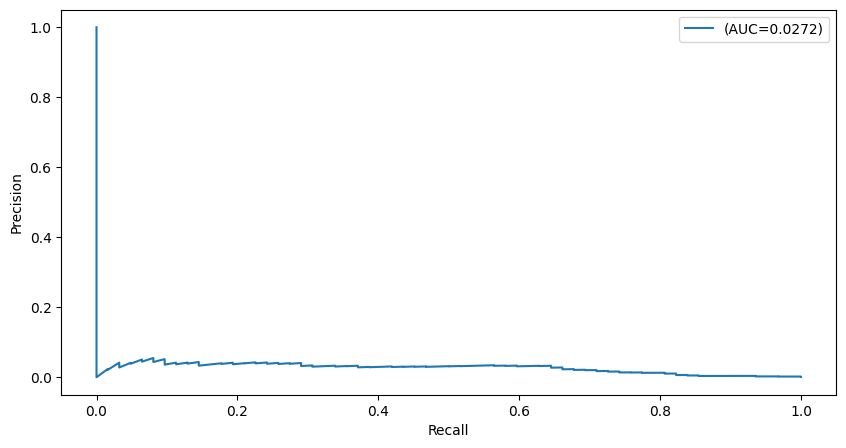

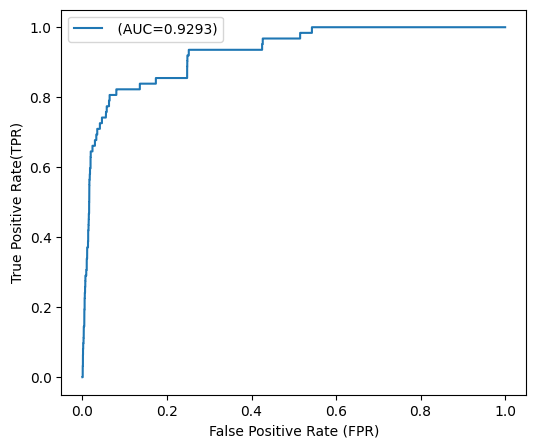

In [19]:
#attention
precision, recall, thresh_pr, ap, fpr, tpr, thresh_roc, roc= pr_roc(hART,X_test,y_test)
#plot_pr_zoomed(precision, recall, ap)
plot_pr(precision, recall, ap)
#plot_roc_zoomed(fpr, tpr, roc)
plot_roc(fpr, tpr, roc)

13/13 [==============================] - 3s 48ms/step


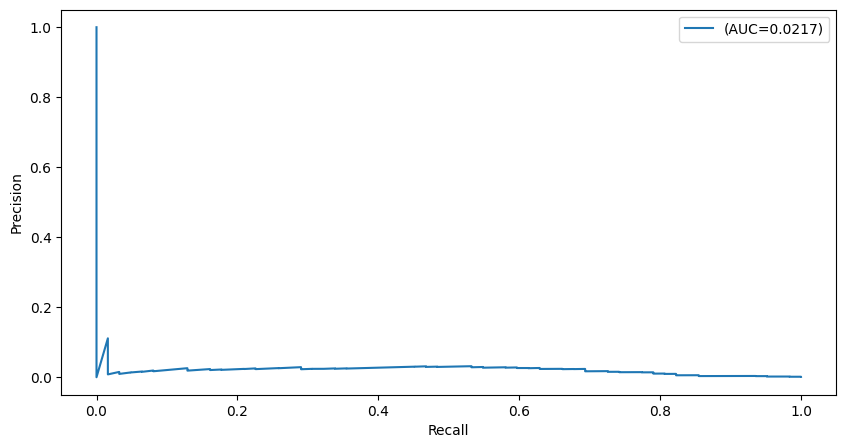

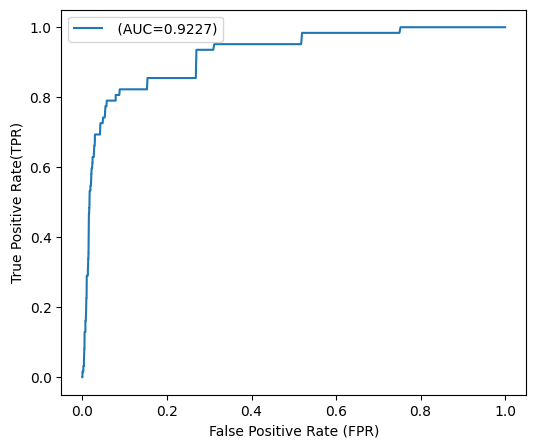

In [20]:
#GRU
precision1, recall1, thresh_pr1, ap1, fpr1, tpr1, thresh_roc1, roc1= pr_roc(DHTM,X_test,y_test)
#plot_pr_zoomed(precision, recall, ap)
plot_pr(precision1, recall1, ap1)
#plot_roc_zoomed(fpr, tpr, roc)
plot_roc(fpr1, tpr1, roc1)

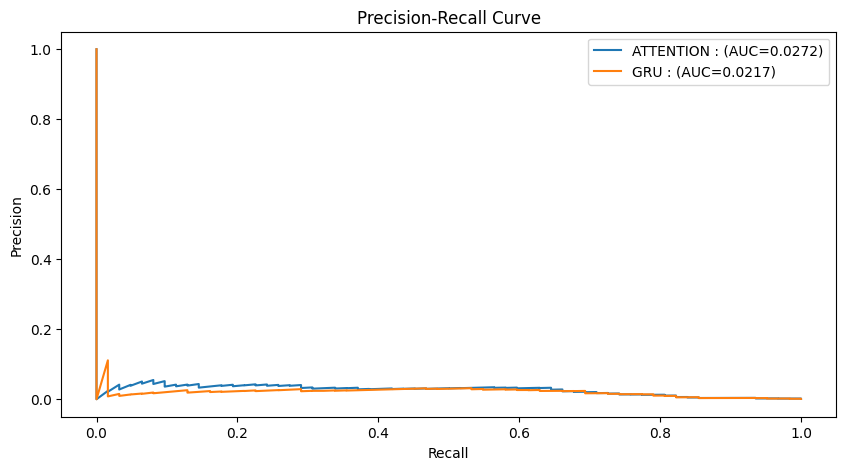

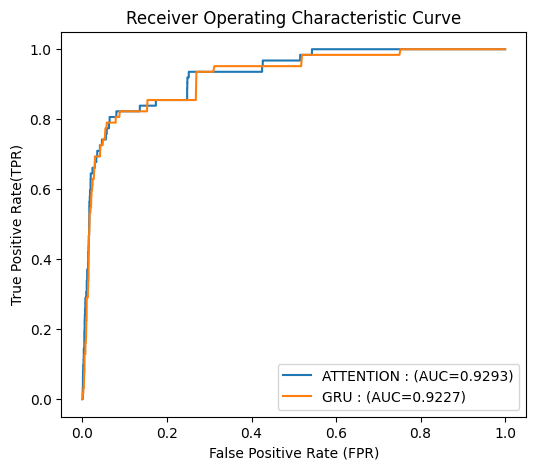

In [21]:
#Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label=f'ATTENTION : (AUC={ap:.4f})')
plt.plot(recall1, precision1, label=f'GRU : (AUC={ap1:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()


#Receiver Operating Characteristic Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ATTENTION : (AUC={roc:.4f})')
plt.plot(fpr1, tpr1, label=f'GRU : (AUC={roc1:.4f})')
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.legend()




# Patient Population Trajectory Sample

In [24]:
########## HELPER FUNCTION FOR TRAJECTORY GRAPHS ####################


######## 1. HEART FAILURE TRAJECTORY (hART PREDICTED)  ############

#### Estimated Actual HF history ######
def traj_int(model,test,start,n):
  t = []
  #start = start.apply(lambda age: round(age * 2))
  #print(min(start))
  for i in range(n):
    data = model.predict(test[i].reshape((1,150,23)))
    data = data.squeeze()
    #data = 1/data
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    age = start[i]
    y = data[-age:]
    t.append(data)

  # Initialize the resulting count array with zeros
  count = [0] * 150
  # Loop through each array and update the count array
  for arr in t:
      for i in range(len(arr)):
          count[i] += 1
  count = [1 if value == 0 else value for value in count]
  return t,count

def test_pad(cms):
  len = []
  for i in cms:
    len.append(i.shape[0])
  cms = pad_sequences(cms, value=-1, padding='post',maxlen=150,dtype='float32')
  return cms,len


######## 2. SIMPLIFIED ATTENTION MATRIX (hART GENERATED) #############

def interpret(model,test,n):
######  FIRST ATTENTION LAYER ###########
  new_model = Model(inputs=model.input, outputs=model.layers[3].output)

  sum = []
  for i in range(n):
    q = np.dot(test[i], np.array(model.layers[4].get_weights()[0])) + np.array(model.layers[4].get_weights()[1])
    k = np.dot(test[i], np.array(model.layers[6].get_weights()[0])) + np.array(model.layers[6].get_weights()[1])
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    att = np.array(tf.nn.softmax(matmul_qk / tf.math.sqrt(dk), axis=-1))
    sum.append(att)

######  SECOND ATTENTION LAYER ###########
  new_model1 = Model(inputs=model.input, outputs=model.layers[23].output)

  sum1 = []
  for i in range(n):
    o = new_model1.predict(test[i].reshape(1,150,23))
    q = np.dot(o.squeeze(), np.array(model.layers[24].get_weights()[0])) + np.array(model.layers[24].get_weights()[1])
    k = np.dot(o.squeeze(), np.array(model.layers[29].get_weights()[0])) + np.array(model.layers[29].get_weights()[1])
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    att = np.array(tf.nn.softmax(matmul_qk / tf.math.sqrt(dk), axis=-1))
    sum1.append(att)

  #How you want merge attention weights (Addition)

  sum = np.mean(sum, axis=0)
  sum = sum[::2, ::2]
  sum1 = np.mean(sum1, axis=0)
  sum1 = sum1[::2, ::2]

  sum_final = sum+sum1
  scaler = MinMaxScaler()
  sum_final= scaler.fit_transform(sum_final)
  # Create a heatmap using seaborn with the specified mask
  #sns.set()
  #plt.figure(figsize=(10, 6))
  #mask = np.triu(np.ones_like(sum, dtype=bool))
  #ax = sns.heatmap(sum, mask=mask, cmap="Blues")
  return sum_final

############ 3. ACTUAL INCIDENCE OF HF ################

def plot_dist(df, col):
    df = df[df['age_end']<75.0]
    #df = df.dropna(axis=0, how='all', subset=[f'age_HFH{i}' for i in range(1, 37)])
    HFH = [f'age_HFH{i}' for i in range(1, 37)]
    # Merge all HF age columns into one
    age_HF = pd.concat([df[col] for col in HFH])

    # Separate patients into two subgroups based on severeCHD_col
    subgroup1 = df[df[col] == 1]
    subgroup2 = df[df[col] == 0]


    # Calculate the distribution of HF over age for each subgroup
    bin_width = 5
    age_bins = np.arange(1, 80, bin_width)
    HF_dist1, _ = np.histogram(subgroup1[HFH].values.flatten(), bins=age_bins)
    HF_dist2, _ = np.histogram(subgroup2[HFH].values.flatten(), bins=age_bins)

    # Calculate the denominator for each age bin
    n1 = np.array([len(subgroup1[(subgroup1['age_enter'] < age) & (subgroup1['age_end'] > age)]) for age in age_bins[:-1]])
    n2 = np.array([len(subgroup2[(subgroup2['age_enter'] < age) & (subgroup2['age_end'] > age)]) for age in age_bins[:-1]])

    # Calculate the average number of HF occurrences per age bin for each subgroup
    HF_dist1 = HF_dist1 / n1 / bin_width
    HF_dist2 = HF_dist2 / n2 / bin_width

    # Calculate the AUC for each curve
    #auc1 = auc(age_bins[:-1], HF_dist1)
    #auc2 = auc(age_bins[:-1], HF_dist2)

    # Plot the distributions
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(age_bins[:-1], HF_dist1, color=(0.3, 0.6, 0.9), label='Severe CHD')
    ax.plot(age_bins[:-1], HF_dist2, color=(1, 0.6, 0), label='Non Severe CHD')
    ax.set_xlabel('Age at Heart Failure (years)')
    ax.set_ylabel('Average Number of Heart Failures')
    ax.set_title('Distribution of Heart Failure\nBased on Severity of CHD', fontsize=16)
    ax.legend()
    ax.set_xlim(0, 75)
    plt.show()
    """
    return age_bins[:-1], HF_dist1, HF_dist2




100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


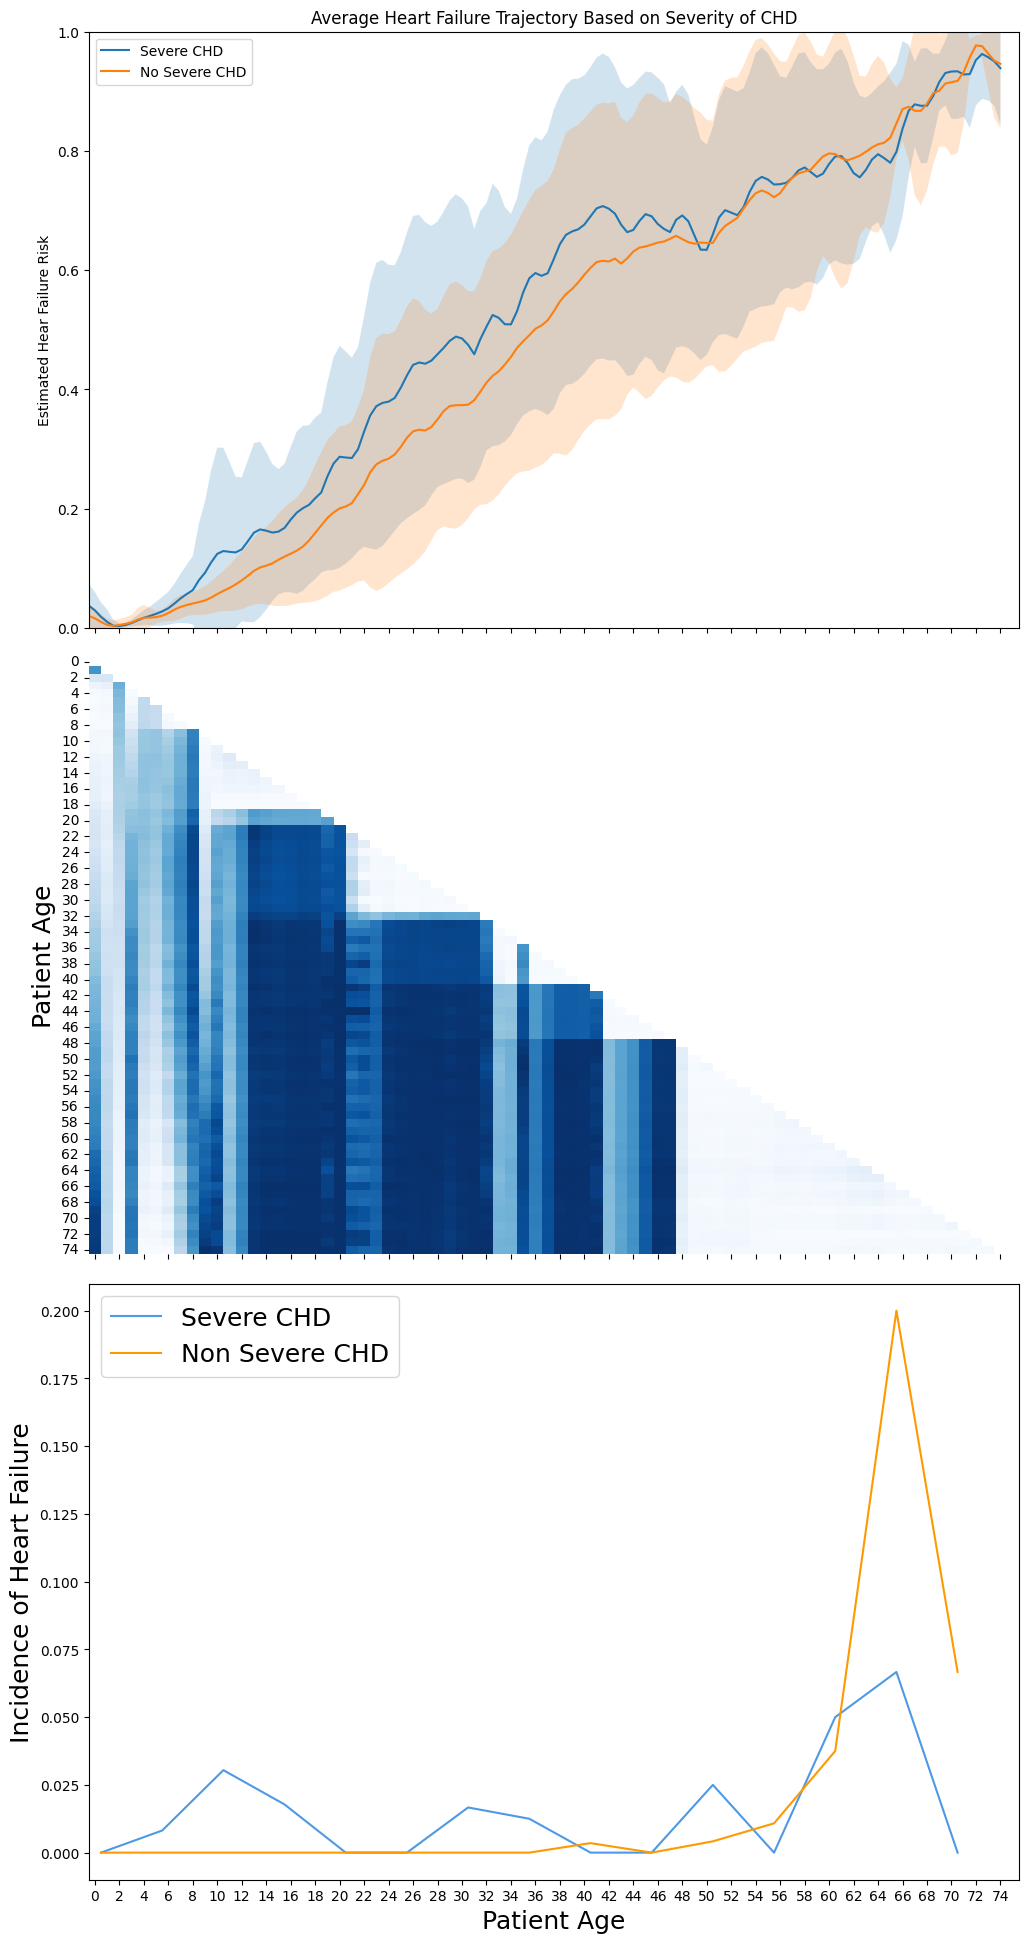

In [25]:
############ CREATING HF TRAJECTORIES ###############

######## Select subgroup you want to analyze (EXAMPLE: Based on Severity)
n=10 #sample size

df_yes = df_test[df_test['severeCHD'] ==1].sample(n)
df_no = df_test[df_test['severeCHD'] ==0].sample(n)

ids_yes,cms_yes, hf_labels_yes = preprocess(df_yes)
ids_no,cms_no,hf_labels_no = preprocess(df_no)

test_yes= test_pad(cms_yes)
test_no= test_pad(cms_no)
a, a_count = traj_int(hART,test_yes[0],test_yes[1],n)
b, b_count = traj_int(hART,test_no[0],test_no[1],n)


# Set up the figure and the axes
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 24))

# Graph Estimated HF trajectories
mean_values = np.mean(a, axis=0)
std_values = np.std(a, axis=0)
mean_values1 = np.mean(b, axis=0)
std_values1 = np.std(b, axis=0)
x = []
value = 0
for i in range(150):
  x.append(value)
  value = value+0.5
ax1.plot(x, mean_values, label='Severe CHD')
ax1.fill_between(x, mean_values - std_values, mean_values + std_values, alpha=0.2)
ax1.plot(x, mean_values1, label='No Severe CHD')
ax1.fill_between(x, mean_values1 - std_values1, mean_values1 + std_values1, alpha=0.2)
ax1.set_ylabel('Estimated Hear Failure Risk')
ax1.set_title('Average Heart Failure Trajectory Based on Severity of CHD')
ax1.set_ylim([0, 1.0])
ax1.set_xlim([0, 75.0])
ax1.legend()


# Graph a heatmap using seaborn with the specified mask
sum = interpret(hART,test_yes[0],n)
mask = np.triu(np.ones_like(sum, dtype=bool))
sns.heatmap(sum, mask=mask, cmap="Blues", cbar=False, ax=ax2)
ax2.set_ylabel('Patient Age', fontsize=18)

# Graph Distribution of HF
age_bins, HF_dist1, HF_dist2 = plot_dist(df_test, 'severeCHD')
ax3.plot(age_bins, HF_dist1, color=(0.3, 0.6, 0.9), label='Severe CHD')
ax3.plot(age_bins, HF_dist2, color=(1, 0.6, 0), label='Non Severe CHD')
ax3.set_xlabel('Patient Age', fontsize=18)
ax3.set_ylabel('Incidence of Heart Failure', fontsize=18)
#ax3.set_title('Distribution of Heart Failure\nBased on Severity of CHD', fontsize=16)
ax3.set_xlim([0, 76.0])
#ax3.set_xticks([*ax3.get_xticks(), 75.0])
#ax3.set_xticklabels(['0','5','10','15','20', '25','30','35','40','45','50','55','60','65','70','75'], fontsize=16)
#ax3.set_yticklabels(ax3.get_yticks(), fontsize=16)
# Set y-axis formatter to remove decimal points
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
ax3.legend(fontsize=18)

# Display the plot
fig.subplots_adjust(hspace=0.05)
plt.show()



# Individualized Trajectory Sample

In [26]:
########## HELPER FUNCTION FOR TRAJECTORY GRAPHS ####################

######## 1. HEART FAILURE TRAJECTORY (hART PREDICTED)  ############

#### Estimated Actual HF history ######
def traj_int(model,test,start,n):
  t = []
  #start = start.apply(lambda age: round(age * 2))
  #print(min(start))
  for i in range(n):
    data = model.predict(test[i].reshape((1,150,23)))
    data = data.squeeze()
    #data = 1/data
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    age = start[i]
    y = data[-age:]
    t.append(data)

  # Initialize the resulting count array with zeros
  count = [0] * 150
  # Loop through each array and update the count array
  for arr in t:
      for i in range(len(arr)):
          count[i] += 1
  count = [1 if value == 0 else value for value in count]
  return t,count

def test_pad(cms):
  len = []
  for i in cms:
    len.append(i.shape[0])
  cms = pad_sequences(cms, value=-1, padding='post',maxlen=150,dtype='float32')
  return cms,len

####### 2. MEDICAL EVENT SUMMARY (Patient Specific)

# Define a custom function to extract the value 0 from dictionaries
def extract_zero_value(d):
    return d.get('patient', None)

def merge(df):
  hf_cols = [f'age_HFH{i}' for i in range(1, 37)]
  mi_cols = [f'age_MI{i}' for i in range(1, 19)]
  stroke_cols = [f'age_Stroke{i}' for i in range(1, 33)]
  ie_cols = [f'age_IE{i}' for i in range(1, 31)]
  arr_cols = [f'age_ARR{i}' for i in range(1, 274)]
  varr_cols =[f'age_VARR{i}' for i in range(1, 101)]
  congsx_cols =[f'age_CONGSX{i}' for i in range(1, 8)]
  arrsx_cols =[f'age_ARRSX{i}' for i in range(1, 4)]
  pcl_cols =[f'age_PCI{i}' for i in range(1, 45)]
  sepsis_cols =[f'age_Sepsis{i}' for i in range(1, 17)]
  akd_cols =[f'age_AKD{i}' for i in range(1, 290)]

  df1 = pd.DataFrame()

  # add all dictionaries
  df1['hf'] = df[hf_cols].sum(axis=1)
  df1['mi'] = df[mi_cols].sum(axis=1)
  df1['stroke'] = df[stroke_cols].sum(axis=1)
  df1['ie'] = df[ie_cols].sum(axis=1)
  df1['arr'] = df[arr_cols].sum(axis=1)
  df1['varr'] = df[varr_cols].sum(axis=1)
  df1['congsx'] = df[congsx_cols].sum(axis=1)
  df1['arrsx'] = df[arrsx_cols].sum(axis=1)
  df1['pcl'] = df[pcl_cols].sum(axis=1)
  df1['sepsis'] = df[sepsis_cols].sum(axis=1)
  df1['akd'] = df[akd_cols].sum(axis=1)
  df1['cad'] = df['age_CAD'].apply(extract_zero_value)
  df1['HPT'] = df['age_HPT'].apply(extract_zero_value)
  df1['ph'] = df['age_PH'].apply(extract_zero_value)
  df1['diab'] = df['age_DIAB'].apply(extract_zero_value)
  df1['ckd'] = df['age_CKD'].apply(extract_zero_value)
  df1['cld'] = df['age_CLD'].apply(extract_zero_value)
  df1['copd'] = df['age_COPD'].apply(extract_zero_value)
  df1['osa'] = df['age_OSA'].apply(extract_zero_value)
  return df1
"""
columns = df_test.columns[8:].tolist()
counts = one(df_test, 9, columns, 75)
count = merge(counts)
y_labels = ['hf', 'mi', 'stroke', 'ie', 'arr', 'varr', 'congsx', 'arrsx', 'pcl','sepsis', 'akd', 'cad', 'HPT', 'ph', 'diab', 'ckd', 'cld', 'copd','osa']
y_labels_fontsize = 16
sns.heatmap(count.T, cmap='Blues', cbar=False)

"""


######## 3. SIMPLIFIED ATTENTION MATRIX (hART GENERATED) #############

def interpret(model,test,n):
######  FIRST ATTENTION LAYER ###########
  new_model = Model(inputs=model.input, outputs=model.layers[3].output)

  sum = []
  for i in range(n):
    q = np.dot(test[i], np.array(model.layers[4].get_weights()[0])) + np.array(model.layers[4].get_weights()[1])
    k = np.dot(test[i], np.array(model.layers[6].get_weights()[0])) + np.array(model.layers[6].get_weights()[1])
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    att = np.array(tf.nn.softmax(matmul_qk / tf.math.sqrt(dk), axis=-1))
    sum.append(att)

######  SECOND ATTENTION LAYER ###########
  new_model1 = Model(inputs=model.input, outputs=model.layers[23].output)

  sum1 = []
  for i in range(n):
    o = new_model1.predict(test[i].reshape(1,150,23))
    q = np.dot(o.squeeze(), np.array(model.layers[24].get_weights()[0])) + np.array(model.layers[24].get_weights()[1])
    k = np.dot(o.squeeze(), np.array(model.layers[29].get_weights()[0])) + np.array(model.layers[29].get_weights()[1])
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    att = np.array(tf.nn.softmax(matmul_qk / tf.math.sqrt(dk), axis=-1))
    sum1.append(att)

  #How you want merge attention weights (Addition)

  sum = np.mean(sum, axis=0)
  sum = sum[::2, ::2]
  sum1 = np.mean(sum1, axis=0)
  sum1 = sum1[::2, ::2]

  sum_final = sum+sum1
  scaler = MinMaxScaler()
  sum_final= scaler.fit_transform(sum_final)
  # Create a heatmap using seaborn with the specified mask
  #sns.set()
  #plt.figure(figsize=(10, 6))
  #mask = np.triu(np.ones_like(sum, dtype=bool))
  #ax = sns.heatmap(sum, mask=mask, cmap="Blues")
  return sum_final





100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 30ms/step


<ipython-input-26-d96d9635f8c9>:57: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1['hf'] = df[hf_cols].sum(axis=1)
<ipython-input-26-d96d9635f8c9>:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1['mi'] = df[mi_cols].sum(axis=1)
<ipython-input-26-d96d9635f8c9>:59: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1['stroke'] = df[stroke_cols].sum(axis=1)
<ipython-input-26-d96d9635f8c9>:60: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None

1/1 [==============================] - 0s 165ms/step


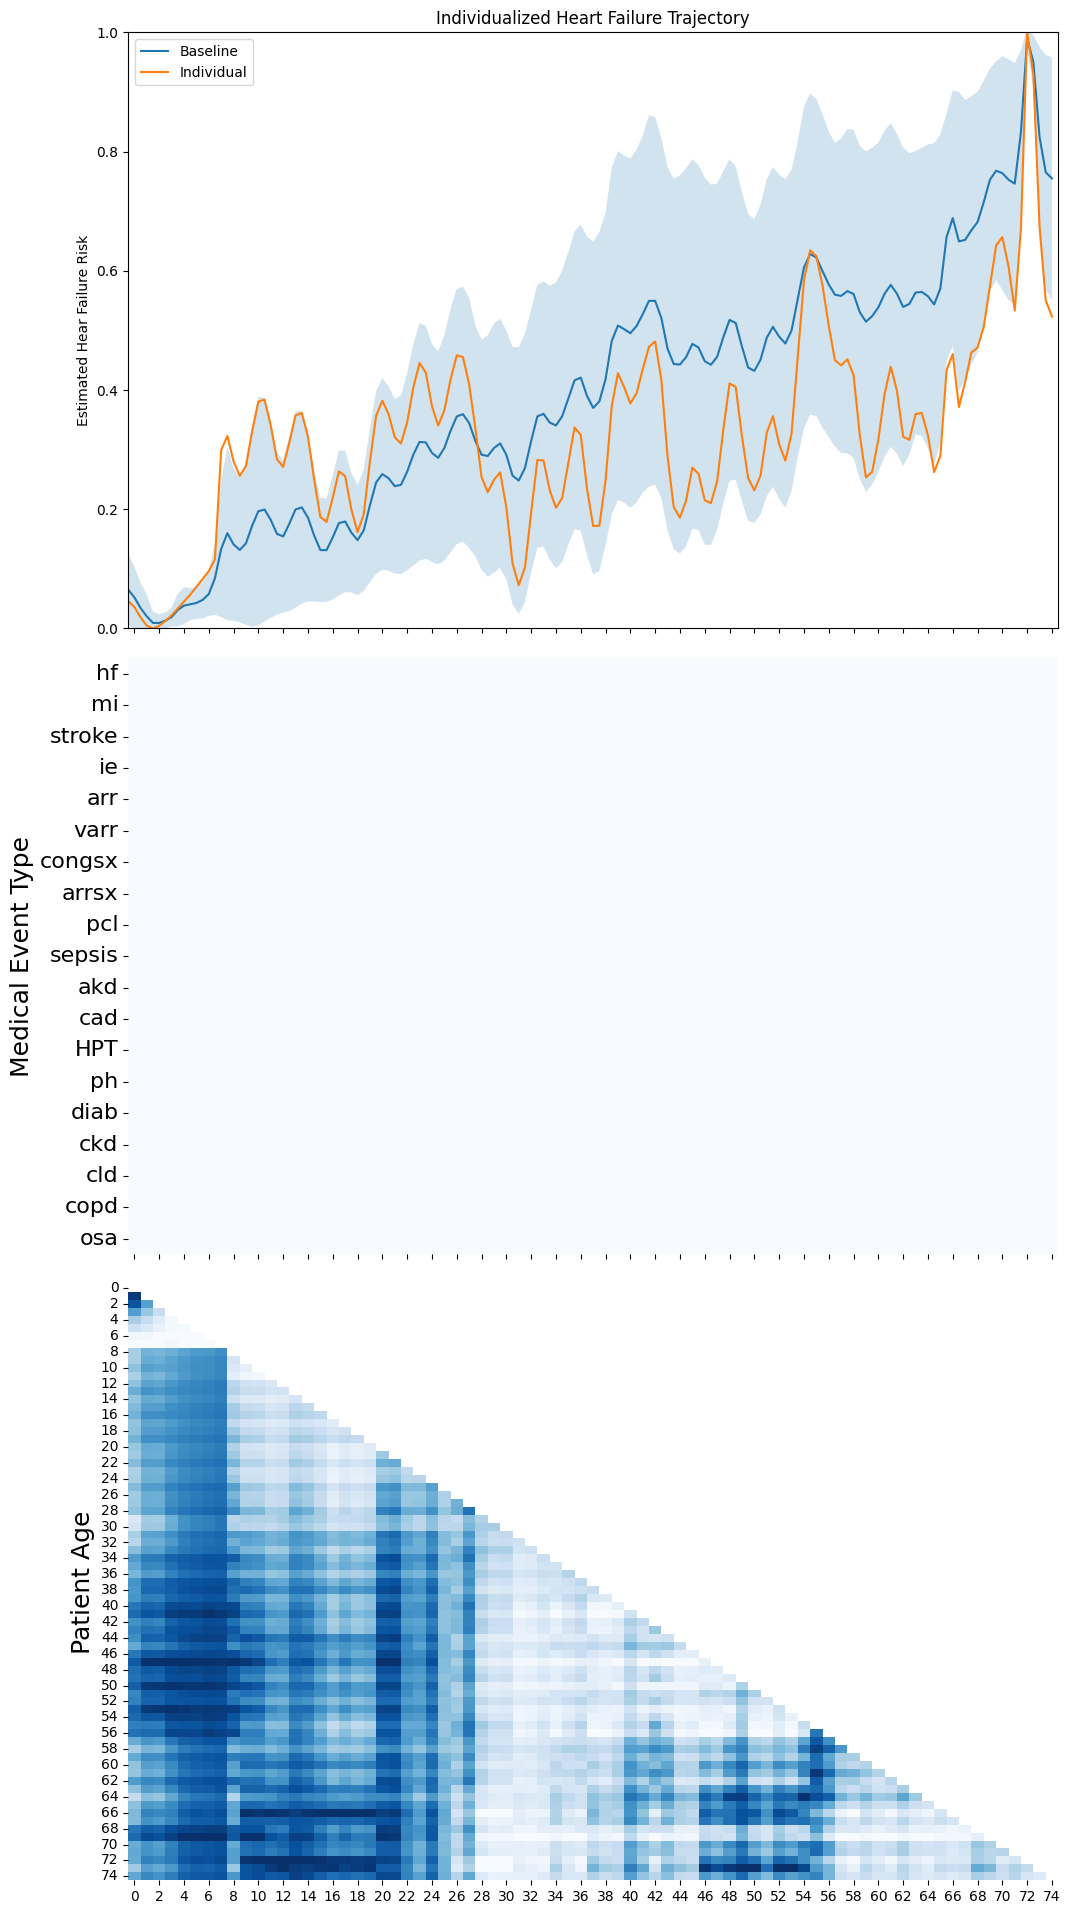

In [27]:
############ CREATING HF TRAJECTORIES ###############

######## Select subgroup you want to analyze (EXAMPLE: Based on Severity)

#pick your patient
patient = 2

#CHOOSE BASELINE AND COMPUTE TRAJECTORY
df_baseline = df_test[df_test['severeCHD'] == 0].sample(10) #### this can be any subset
ids_base,cms_base, hf_labels_base = preprocess(df_baseline)
test_base= test_pad(cms_base)
a, a_count = traj_int(hART,test_base[0],test_base[1],df_baseline.shape[0])

# PICK RANDOM INDIVIDUAL PATIENT
one = hART.predict(test_base[0][patient].reshape((1,150,23)))
one = one.squeeze()
one = (one - np.min(one)) / (np.max(one) - np.min(one))

# Set up the figure and the axes
fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 24))

# Graph Estimated HF trajectories
mean_values = np.mean(a, axis=0)
std_values = np.std(a, axis=0)

x = []
value = 0
for i in range(150):
  x.append(value)
  value = value+0.5
ax1.plot(x, mean_values, label='Baseline')
ax1.fill_between(x, mean_values - std_values, mean_values + std_values, alpha=0.2)
ax1.plot(x, one, label='Individual')
ax1.set_ylabel('Estimated Hear Failure Risk')
ax1.set_title('Individualized Heart Failure Trajectory')
ax1.set_ylim([0, 1.0])
ax1.set_xlim([0, 75.0])
ax1.legend()


# Create the second plot : MEDICAL EVENTS

columns = df_baseline.columns[8:].tolist()
df_one = pd.DataFrame(df_baseline.iloc[patient]).T
counts = {time_var: {i: {'patient': 0} for i in range(int(75)+1)} for time_var in columns}
# Loop through each time_var and count the number of occurrences at each time step
for time_var in columns:
  for i in range(int(75)+1):
    time_step = i
    counts[time_var][time_step]['patient'] = len(df_one[(df_one[time_var] >= time_step) & (df_one[time_var] < time_step+1)])
count = merge(pd.DataFrame(counts))
y_labels = ['hf', 'mi', 'stroke', 'ie', 'arr', 'varr', 'congsx', 'arrsx', 'pcl','sepsis', 'akd', 'cad', 'HPT', 'ph', 'diab', 'ckd', 'cld', 'copd','osa']
y_labels_fontsize = 16
sns.heatmap(count.T, cmap='Blues', cbar=False, ax=ax2)
ax2.set_ylabel('Medical Event Type', fontsize=18)
ax2.set_yticklabels(y_labels, fontsize=y_labels_fontsize)

# Graph a heatmap using seaborn with the specified mask

new_model = Model(inputs=hART.input, outputs=hART.layers[3].output)
q = np.dot(test_base[0][patient], np.array(hART.layers[4].get_weights()[0])) + np.array(hART.layers[4].get_weights()[1])
k = np.dot(test_base[0][patient], np.array(hART.layers[6].get_weights()[0])) + np.array(hART.layers[6].get_weights()[1])
matmul_qk = tf.matmul(q, k, transpose_b=True)
dk = tf.cast(tf.shape(k)[-1], tf.float32)
att = np.array(tf.nn.softmax(matmul_qk / tf.math.sqrt(dk), axis=-1))

new_model1 = Model(inputs=hART.input, outputs=hART.layers[23].output)
o = new_model1.predict(test_base[0][patient].reshape(1,150,23))
q = np.dot(o.squeeze(), np.array(hART.layers[24].get_weights()[0])) + np.array(hART.layers[24].get_weights()[1])
k = np.dot(o.squeeze(), np.array(hART.layers[29].get_weights()[0])) + np.array(hART.layers[29].get_weights()[1])
matmul_qk = tf.matmul(q, k, transpose_b=True)
dk = tf.cast(tf.shape(k)[-1], tf.float32)
att1 = np.array(tf.nn.softmax(matmul_qk / tf.math.sqrt(dk), axis=-1))

att = att[::2, ::2]
att1 = att1[::2, ::2]

att_final = att+att1
scaler = MinMaxScaler()
att_final= scaler.fit_transform(att_final)

mask = np.triu(np.ones_like(att_final, dtype=bool))
sns.heatmap(att_final, mask=mask, cmap="Blues", cbar=False, ax=ax3)
ax3.set_ylabel('Patient Age', fontsize=18)


# Display the plot
fig.subplots_adjust(hspace=0.05)
plt.show()

